In [153]:
!pip install backtesting

In [154]:
!pip install ta

In [155]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from IPython.display import clear_output
import time
import datetime
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ta import add_all_ta_features
from ta.utils import dropna

In [156]:
class price_sim:

  """
    A Python class for simulating and analyzing financial price data using Geometric Brownian Motion (GBM).

    This class provides a set of functions to load historical price data, calculate returns, simulate GBM,
    and visualize the results. It includes functionalities for both regular simulation and backtesting.

    Attributes:
        - ticker (str): Ticker symbol for the financial instrument.
        - start_date (list): Start date [year, month, day] for historical data loading.
        - end_date (list/str): End date [year, month, day] or 'today' for historical data loading.
        - interval (str): Data interval (e.g., '1d') for historical data loading.
        - predicted_period (int): Number of periods for future price simulation.
        - backtesting (bool): True for backtesting, False for regular simulation.

    Functions:
        - data_loading: Compiles historical price data from Yahoo Finance for a specified ticker.
        - returnify: Calculates simple returns for provided financial data.
        - log_returnify: Calculates log returns for provided financial data.
        - GBM_params: Calculates mean and standard deviation of returns.
        - GBM: Simulates Geometric Brownian Motion for a given set of parameters.
        - plot_paths: Plots realizations of GBM along with actual exchange rates.
        - plot_paths_on_profit_space: Plots realizations of GBM with profit space boundaries.
        - pipeline: Executes the complete pipeline for GBM simulation and visualization.

    Note:
        - The class assumes the use of Pandas for handling financial data and NumPy for numerical operations.
        - Visualization functionalities use Matplotlib for plotting.
  """

  def data_loading(self, ticker, start_date, end_date, interval):

      """
      - Calculates log returns for the provided financial data.

    - Parameters:
          - FX_data (Pandas DataFrame): Financial data.
          - date_col (str, optional): Column containing dates.

      - Returns:
        - Pandas DataFrame with dates and corresponding log returns.
      """

      self.ticker = ticker
      self.start_date = start_date
      self.end_date = end_date
      self.interval = interval

      yh_start_date = int(time.mktime(datetime.datetime(self.start_date[0], self.start_date[1], self.start_date[2], 23, 59).timetuple()))

      if self.end_date == 'today':
        yh_end_date = int(time.mktime(datetime.datetime.now().timetuple()))
      else:
        yh_end_date = int(time.mktime(datetime.datetime(self.end_date[0], self.end_date[1], self.end_date[2], 23, 59).timetuple()))

      query_string1 = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={yh_start_date}&period2={yh_end_date}&interval={self.interval}&events=history&includeAdjustedClose=true'

      FX_data = pd.read_csv(query_string1)
      FX_data['Adj Close'] = FX_data['Adj Close']

      return FX_data

  def returnify(self, FX_data, date_col = None):

      """
      - Calculates simple returns for the provided financial data.

     - Parameters:
          - FX_data (Pandas DataFrame): Financial data.
          - date_col (str, optional): Column containing dates.

      - Returns:
          - Pandas DataFrame with dates and corresponding returns.
      """

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[date_col]
        returns = prices / prices.shift(1) - 1
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = prices / prices.shift(1) - 1
        returnified = returns

      return returnified

  def log_returnify(self, FX_data, date_col = None):

      """
    - Calculates log returns for the provided financial data.

    - Parameters:
        - FX_data (Pandas DataFrame): Financial data.
        - date_col (str, optional): Column containing dates.

    - Returns:
        - Pandas DataFrame with dates and corresponding log returns.
      """

      self.FX_data = FX_data
      self.date_col = date_col

      if self.date_col != None:
        prices = self.FX_data.loc[:, self.FX_data.columns != self.date_col]
        dates = self.FX_data[self.date_col]
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = pd.concat([dates, returns], axis = 1,)

      else:
        prices = self.FX_data
        returns = np.log(prices) - np.log(prices.shift(1))
        returnified = returns

      return returnified

  def streak_logic(self, last_streak, t0_value, tm1_value):

      if ((t0_value > 0) and (tm1_value >0)) or ((t0_value < 0) and (tm1_value < 0)):
        last_streak +=1
      elif ((t0_value > 0) and (tm1_value < 0)) or ((t0_value < 0) and (tm1_value > 0)):
        last_streak = 1
      elif t0_value == 0:
        last_streak = last_streak

      return last_streak

  def streak_counter(self, pd_series):
      streak = 0
      streak_series = pd.Series(1)

      for i in range(1, len(pd_series)):
        t0_value = pd_series[i]
        tm1_value = pd_series[i-1]

        streak = self.streak_logic(streak, t0_value, tm1_value)

        streak_series = pd.concat([streak_series, pd.Series(streak)], axis = 1, ignore_index= True)

      return streak_series

  def GBM_params(self, returns):

      """
    - Calculates the mean (mu) and standard deviation (sigma) of returns.

    - Parameters:
        - returns (Pandas Series): Financial returns.

    - Returns:
        - Tuple (mu, sigma) representing mean and standard deviation.
      """

      self.returns = returns

      mu = self.returns.describe().at['mean']
      sigma = self.returns.describe().at['std']

      return mu, sigma

  def GBM(self, mu, sigma, S0, steps, n_paths, plot = 'N', pandas = 'Y'):

      """
    - Simulates Geometric Brownian Motion (GBM) for a given set of parameters.

    - Parameters:
        - mu (float): Mean of returns.
        - sigma (float): Standard deviation of returns.
        - S0 (float): Initial stock price.
        - steps (int): Number of time steps.
        - n_paths (int): Number of simulation paths.
        - plot (str): 'Y' to plot simulation, 'N' otherwise.
        - pandas (str): 'Y' to return Pandas DataFrame, 'N' for NumPy array.

    - Returns:
        - Pandas DataFrame or NumPy array representing GBM simulation.
      """

      self.mu = mu
      self.sigma = sigma
      self.S0 = S0
      self.steps = steps
      self.n_paths = n_paths
      self.plot = plot
      self.pandas = pandas

      T = 1

      # calc each time step
      dt = T/self.steps

      # simulation using numpy arrays
      St = np.exp(
          (self.mu - self.sigma ** 2 / 2) * dt
          + self.sigma * np.random.normal(0, np.sqrt(dt), size=(self.n_paths,self.steps)).T
      )

      # include array of 1's
      St = np.vstack([np.ones(self.n_paths), St])

      # multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0).
      St = self.S0 * St.cumprod(axis=0)

      if self.plot == 'Y':
        # Define time interval correctly
        time = np.linspace(0,T,self.steps+1)

        # Require numpy array that is the same shape as St
        tt = np.full(shape=(self.n_paths,self.steps+1), fill_value=time).T

        plt.plot(tt, St)
        plt.xlabel("Years $(t)$")
        plt.ylabel("Stock Price $(S_t)$")
        plt.title(
            "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(self.S0, self.mu, self.sigma)
        )
        plt.show()

      if self.pandas == 'Y':
        output_St = pd.DataFrame(St)
      else:
        output_St = St

      return output_St

  def plot_paths(self, sim_df, FX_df, predicted_period, backtesting = False):

    """
    - Plots realizations of Geometric Brownian Motion along with actual exchange rates.

    - Parameters:
        - sim_df (Pandas DataFrame): Simulated GBM data.
        - FX_df (Pandas Series): Actual exchange rate data.
        - predicted_period (int): Number of predicted periods.
        - backtesting (bool): True for backtesting, False for regular simulation.
    """

    self.ticker = 'USD-Y'

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    #plt.plot(tt_fx, temp)#, linewidth = 1, c = 'k')
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Rate $(S_t)$")
    plt.title(
            "Realizations of Geometric Brownian Motion of {3}\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(round(self.S0,6), round(self.mu,6), round(self.sigma,6), self.ticker)
        )
    plt.grid()
    plt.show()

  def plot_paths_on_profit_space(self, sim_df, FX_df, predicted_period, avg_returns, backtesting = False):

    """
    - Plots realizations of Geometric Brownian Motion with profit space boundaries.

    - Parameters:
        - sim_df (Pandas DataFrame): Simulated GBM data.
        - FX_df (Pandas Series): Actual exchange rate data.
        - predicted_period (int): Number of predicted periods.
        - avg_returns (float): Average returns for profit space boundaries.
        - backtesting (bool): True for backtesting, False for regular simulation.
    """

    t_start = 0
    t_end = 1
    t_step = 1/predicted_period

    avg_fee_rate = avg_returns

    profit_space = pd.DataFrame(columns=['t','bounds_x1', 'bounds_x2'])
    profit_space['t'] = pd.Series(np.arange(t_start-t_step,t_end,t_step))

    bounds_x1 = pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], 0))
    bounds_x2 = pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], 0))


    for i in range(1, len(profit_space)):
        bounds_x1 = pd.concat([bounds_x1, pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], (((1+avg_fee_rate)**i)-1))[0])])
        bounds_x2 = pd.concat([bounds_x2, pd.Series(profitability_bounds(FX_df.iloc[-predicted_period-1], (((1+avg_fee_rate)**i)-1))[1])])

    profit_space['bounds_x1'] = bounds_x1.reset_index(drop=True)
    profit_space['bounds_x2'] = bounds_x2.reset_index(drop=True)

    self.ticker = 'USD-Y'

    self.sim_df = sim_df
    self.FX_df = FX_df
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    time_space = np.linspace(0,1,self.predicted_period+1)
    tt = np.full(shape=(10000, self.predicted_period + 1), fill_value=time_space).T
    tt_fx = np.full(shape=(1, self.predicted_period + 1), fill_value=time_space).T

    temp = self.FX_df[self.FX_df.index >= len(self.FX_df)-self.predicted_period-1].reset_index(drop = True)

    if self.backtesting == True:
      plot_df = self.sim_df
    else:
      df_nan = pd.DataFrame(np.nan, index=range(self.predicted_period), columns=range(len(self.sim_df.columns)))
      plot_df = pd.concat([df_nan, self.sim_df]).reset_index(drop = True)
      temp = pd.concat([temp, df_nan]).reset_index(drop = True)
      time_space = np.linspace(0,1,2*self.predicted_period+1)
      tt = np.full(shape=(10000, 2*self.predicted_period + 1), fill_value=time_space).T
      tt_fx = np.full(shape=(1, 2*self.predicted_period + 1), fill_value=time_space).T

    fig = plt.figure(figsize=(8,5))
    plt.plot(tt, plot_df)
    #plt.plot(tt_fx, temp)#, linewidth = 1, c = 'k')
    x = profit_space['t']
    y1 = profit_space['bounds_x1']
    y2 = profit_space['bounds_x2']

    plt.fill_between(x, y1, y2, alpha=0.4)
    plt.xlabel("Years $(t)$")
    plt.ylabel("Exchange Rate $(S_t)$")
    plt.title(
            "Realizations of Geometric Brownian Motion of {3}\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(round(self.S0,6), round(self.mu,6), round(self.sigma,6), self.ticker)
        )
    plt.grid()
    plt.show()

  def pipeline(self, predicted_period, FX_data = pd.DataFrame(), ticker = '', start_date = [], end_date = [], interval = '', backtesting = True, plot_sim = False,):

    """
    - Executes the complete pipeline for Geometric Brownian Motion simulation and visualization.

    - Parameters:
        - predicted_period (int): Number of predicted periods.
        - FX_data (Pandas DataFrame, optional): Historical price data.
        - ticker (str): Ticker symbol.
        - start_date (list): Start date [year, month, day].
        - end_date (list/str): End date [year, month, day] or 'today'.
        - interval (str): Data interval (e.g., '1d').
        - backtesting (bool): True for backtesting, False for regular simulation.
        - plot_sim (bool): True to plot the simulation, False otherwise.
    """

    self.ticker = ticker
    self.start_date = start_date
    self.end_date = end_date
    self.interval = interval
    self.predicted_period = predicted_period
    self.backtesting = backtesting

    if FX_data.empty:
        self.FX_data = self.data_loading(ticker = self.ticker,
                            start_date=self.start_date,
                            end_date=self.end_date,
                            interval=self.interval)
    else:
        self.FX_data = FX_data

    self.returns = self.log_returnify(FX_data = self.FX_data,
                            date_col = 'Date')

    self.mu, self.sigma = self.GBM_params(self.returns['Adj Close'])

    self.sim = self.GBM(
        mu = self.mu*(self.predicted_period**(1/2)),
        sigma = self.sigma*(self.predicted_period**(1/2)),
        S0 = self.FX_data.at[len(self.FX_data)-self.predicted_period-1, 'Adj Close'] if backtesting == True else self.FX_data.at[len(self.FX_data)-1, 'Adj Close'],
        #FX_data.at[len(FX_data)-predicted_period-1, 'Close'],
        steps = self.predicted_period,
        n_paths = 1000)
    self.sim_df = self.sim

    if plot_sim:
        self.plot_paths(
            sim_df = self.sim,
            FX_df = self.FX_data['Adj Close'],
            predicted_period = self.predicted_period,
            backtesting = self.backtesting)

    self.streaks = self.streak_counter(self.returns)


In [157]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

import ta

In [158]:
price2 = price_sim()

price2.pipeline(
                    ticker =  '^GSPC', #'NQ%3DF',   #'^GSPC',
                    start_date=[2003,8,12],
                    end_date='today',
                    interval='1d',
                    predicted_period = 260,
                    backtesting = False)

In [159]:
price = price_sim()

price.pipeline(
                    ticker =  '^NDX', #'NQ%3DF',   #'^GSPC',
                    start_date=[2003,8,12],
                    end_date='today',
                    interval='1d',
                    predicted_period = 260,
                    backtesting = False)

In [160]:
price.FX_data.head()

Date         Open         High          Low        Close    Adj Close      Volume
0  2003-08-12  1227.500000  1241.619995  1220.119995  1240.699951  1240.699951  1329840000
1  2003-08-13  1247.560059  1249.140015  1233.800049  1240.369995  1240.369995  1449200000
2  2003-08-14  1241.170044  1254.000000  1235.050049  1251.900024  1251.900024  1311570000
3  2003-08-15  1250.449951  1257.459961  1246.319946  1253.630005  1253.630005   703950000
4  2003-08-18  1258.180054  1284.880005  1256.900024  1284.810059  1284.810059  1476310000

In [161]:
input_data = price.FX_data.copy()
input_data = input_data.set_index('Date')
input_data.index =pd.to_datetime(input_data.index)

In [162]:
input_data

Open          High           Low         Close     Adj Close      Volume
Date                                                                                        
2003-08-12   1227.500000   1241.619995   1220.119995   1240.699951   1240.699951  1329840000
2003-08-13   1247.560059   1249.140015   1233.800049   1240.369995   1240.369995  1449200000
2003-08-14   1241.170044   1254.000000   1235.050049   1251.900024   1251.900024  1311570000
2003-08-15   1250.449951   1257.459961   1246.319946   1253.630005   1253.630005   703950000
2003-08-18   1258.180054   1284.880005   1256.900024   1284.810059   1284.810059  1476310000
...                  ...           ...           ...           ...           ...         ...
2024-03-06  18083.509766  18142.880859  17941.640625  18017.570313  18017.570313  5511370000
2024-03-07  18161.730469  18337.949219  18101.429688  18297.990234  18297.990234  5072790000
2024-03-08  18312.789063  18416.730469  17995.380859  18018.449219  18018.449219  5411790000
2024-03-11  17959.679688  18003.050781  17873.330078  17951.689453  17951.689453  4917620000
2024-03-12  18063.000000  18228.369141  17919.332031  18219.115234  18219.115234   829651394

[5181 rows x 6 columns]

## Initiation

In [163]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    if crossover(self.rsi, self.upper_bound):
      self.position.close()
    elif crossover(self.lower_bound, self.rsi):
      self.buy()

In [164]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [165]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   74.001158
Equity Final [$]              11723241.500748
Equity Peak [$]               11878943.191992
Return [%]                         1072.32415
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                   12.719146
Volatility (Ann.) [%]                22.57882
Sharpe Ratio                         0.563322
Sortino Ratio                        0.922284
Calmar Ratio                         0.236967
Max. Drawdown [%]                  -53.674757
Avg. Drawdown [%]                   -2.923592
Max. Drawdown Duration     1098 days 00:00:00
Avg. Drawdown Duration       35 days 00:00:00
# Trades                                   10
Win Rate [%]                            100.0
Best Trade [%]                      53.533771
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

In [166]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p6079', ...)

## Optimize function

In [167]:
bt.optimize(
    upper_bound = range(50,85,5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10,20,2)
)

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   48.600656
Equity Final [$]               7385266.148225
Equity Peak [$]                7565128.054285
Return [%]                         638.526615
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    10.21398
Volatility (Ann.) [%]               20.680871
Sharpe Ratio                         0.493885
Sortino Ratio                        0.796742
Calmar Ratio                         0.213879
Max. Drawdown [%]                  -47.755908
Avg. Drawdown [%]                   -3.090791
Max. Drawdown Duration     1435 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   56
Win Rate [%]                        85.714286
Best Trade [%]                      12.442384
Worst Trade [%]                    -23.215721
Avg. Trade [%]                    

### Optimizing certain metric

In [168]:
bt.optimize(
    upper_bound = range(50,85,5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10,20,2),
    maximize = 'Sharpe Ratio'
)

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   55.027987
Equity Final [$]               9952880.261603
Equity Peak [$]               10085070.757559
Return [%]                         895.288026
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    11.82515
Volatility (Ann.) [%]               20.261509
Sharpe Ratio                         0.583626
Sortino Ratio                        0.955709
Calmar Ratio                         0.332518
Max. Drawdown [%]                  -35.562488
Avg. Drawdown [%]                   -2.593559
Max. Drawdown Duration     1884 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                    5
Win Rate [%]                            100.0
Best Trade [%]                     152.621952
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

### Constraint

In [169]:
bt.optimize(
    upper_bound = range(10,85,5),
    lower_bound = range(10, 85, 5),
    rsi_window = range(10,20,2),
    maximize = 'Sharpe Ratio',
    constraint = lambda param: param.upper_bound > param.lower_bound
)

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 525 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                    1.891527
Equity Final [$]                1995129.99955
Equity Peak [$]                 2023159.71819
Return [%]                             99.513
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    3.416629
Volatility (Ann.) [%]                 5.43072
Sharpe Ratio                          0.62913
Sortino Ratio                        1.557037
Calmar Ratio                         0.698601
Max. Drawdown [%]                    -4.89067
Avg. Drawdown [%]                   -1.899943
Max. Drawdown Duration     1084 days 00:00:00
Avg. Drawdown Duration      273 days 00:00:00
# Trades                                   26
Win Rate [%]                        80.769231
Best Trade [%]                      13.261666
Worst Trade [%]                     -4.894929
Avg. Trade [%]                    

### Limiting amount of combinations

In [170]:
bt.optimize(
    upper_bound = range(10,85,5),
    lower_bound = range(10, 85, 5),
    rsi_window = range(10,20,2),
    maximize = 'Sharpe Ratio',
    constraint = lambda param: param.upper_bound > param.lower_bound,
    max_tries = 100
)

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   90.465161
Equity Final [$]              16011156.454057
Equity Peak [$]               16223716.852273
Return [%]                        1501.115645
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                   14.441154
Volatility (Ann.) [%]               24.654553
Sharpe Ratio                          0.58574
Sortino Ratio                        0.970384
Calmar Ratio                         0.268937
Max. Drawdown [%]                  -53.697144
Avg. Drawdown [%]                   -2.947968
Max. Drawdown Duration     1080 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                   12
Win Rate [%]                            100.0
Best Trade [%]                       48.18886
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

### Custom optimalization

In [171]:
def optimalization_func(series):
  return series['Equity Final [$]'] / series['Exposure Time [%]']

In [172]:
bt.optimize(
    upper_bound = range(10,85,5),
    lower_bound = range(10, 85, 5),
    rsi_window = range(10,20,2),
    maximize = optimalization_func,
    constraint = lambda param: param.upper_bound > param.lower_bound
)

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 525 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                    0.038603
Equity Final [$]               1007470.325135
Equity Peak [$]                  1008637.6339
Return [%]                           0.747033
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    0.036207
Volatility (Ann.) [%]                0.192292
Sharpe Ratio                         0.188289
Sortino Ratio                        1.418411
Calmar Ratio                         0.312851
Max. Drawdown [%]                   -0.115731
Avg. Drawdown [%]                   -0.115731
Max. Drawdown Duration     7516 days 00:00:00
Avg. Drawdown Duration     7516 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       0.747674
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

In [173]:
def optimalization_func2(series):

  if series['# Trades'] < 10:
    return -1

  return series['Equity Final [$]'] / series['Exposure Time [%]']

In [174]:
bt.optimize(
    upper_bound = range(10,85,5),
    lower_bound = range(10, 85, 5),
    rsi_window = range(10,20,2),
    maximize = optimalization_func2,
    constraint = lambda param: param.upper_bound > param.lower_bound
)

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 525 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                    0.926462
Equity Final [$]               1746967.905828
Equity Peak [$]                1747509.077628
Return [%]                          74.696791
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    2.750646
Volatility (Ann.) [%]                4.580804
Sharpe Ratio                         0.600472
Sortino Ratio                        1.970577
Calmar Ratio                         0.601913
Max. Drawdown [%]                   -4.569841
Avg. Drawdown [%]                   -1.681817
Max. Drawdown Duration     1623 days 00:00:00
Avg. Drawdown Duration      378 days 00:00:00
# Trades                                   14
Win Rate [%]                        92.857143
Best Trade [%]                      13.261666
Worst Trade [%]                     -0.173512
Avg. Trade [%]                    

### Parameter heatmap
- what combination of parameter result in which metric value

In [175]:
stats, heatmap = bt.optimize(
    upper_bound = range(55,85,5),
    lower_bound = range(10, 45, 5),
    rsi_window = 14,
    maximize = 'Sharpe Ratio',
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
)

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

In [176]:
import seaborn as sns

<Axes: xlabel='lower_bound', ylabel='upper_bound'>

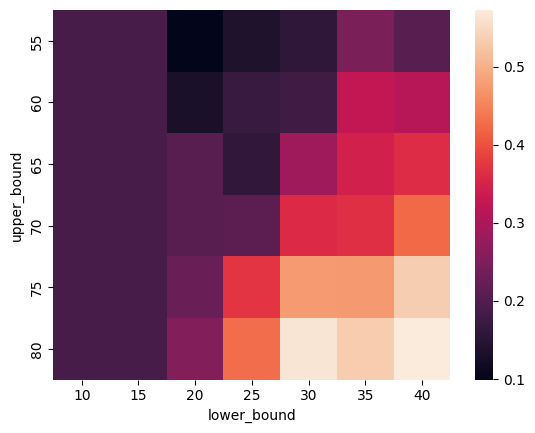

In [177]:
hm = heatmap.groupby(["upper_bound", "lower_bound"]).mean().unstack()
sns.heatmap(hm)

In [178]:
from backtesting.lib import plot_heatmaps

In [179]:
stats, heatmap = bt.optimize(
    upper_bound = range(55,85,5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10,20,2),
    maximize = 'Sharpe Ratio',
    constraint = lambda param: param.upper_bound > param.lower_bound,
    return_heatmap = True
)

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

- averages sharpe ration among the different rsi_windows

In [180]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p6245', ...)

## Strategies

In [181]:
from backtesting.lib import resample_apply

In [182]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.daily_rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)
    self.weekly_rsi = resample_apply(
        "W-FRI", #weekly anchored to FRI, could be SUN for crypto
        ta.momentum.rsi,
        self.data.Close,
        self.rsi_window,
        True
    )

  def next(self): #iterates through each candle
    if (crossover(self.daily_rsi, self.upper_bound) and self.weekly_rsi[-1] > self.upper_bound):
      self.position.close()
    elif (crossover(self.lower_bound, self.daily_rsi)
          and self.weekly_rsi[-1] < self.upper_bound):
          #and self.daily_rsi[-1] < self.weekly_rsi[-1]):
      self.buy()

In [183]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [184]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   91.700444
Equity Final [$]              13498823.583388
Equity Peak [$]                13678036.46992
Return [%]                        1249.882358
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                   13.495007
Volatility (Ann.) [%]               24.318383
Sharpe Ratio                          0.55493
Sortino Ratio                        0.906628
Calmar Ratio                         0.251294
Max. Drawdown [%]                  -53.701977
Avg. Drawdown [%]                   -2.609729
Max. Drawdown Duration     1160 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                     424.539135
Worst Trade [%]                    157.546896
Avg. Trade [%]                    

In [185]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p6649', ...)

## Order types

### Shorting

In [186]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    if crossover(self.rsi, self.upper_bound):
      if self.position.is_long():
        print(self.position.size, self.position.pl_pct)
        self.position.close()
        self.sell()
    elif crossover(self.lower_bound, self.rsi):
      if self.position.is_long() or not self.position:
        self.position.close()
        self.buy()

In [187]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [188]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   99.961397
Equity Final [$]               8283289.297756
Equity Peak [$]                 9168013.43122
Return [%]                          728.32893
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    10.83086
Volatility (Ann.) [%]                25.14075
Sharpe Ratio                         0.430809
Sortino Ratio                         0.70226
Calmar Ratio                         0.201811
Max. Drawdown [%]                  -53.668223
Avg. Drawdown [%]                   -3.620554
Max. Drawdown Duration     1266 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   51
Win Rate [%]                        50.980392
Best Trade [%]                      63.330522
Worst Trade [%]                    -21.226392
Avg. Trade [%]                    

In [189]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p7028', ...)

### Take profit AND Stop loss

In [189]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    price = self.data.Close[-1]
    if crossover(self.rsi, self.upper_bound):
      self.position.close()
    elif crossover(self.lower_bound, self.rsi):
      self.buy(tp=1.15*price, sl=0.95*price) #tp - take profit, sl - stop loss, has to be certain price,

In [190]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [191]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   99.961397
Equity Final [$]               8283289.297756
Equity Peak [$]                 9168013.43122
Return [%]                          728.32893
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    10.83086
Volatility (Ann.) [%]                25.14075
Sharpe Ratio                         0.430809
Sortino Ratio                         0.70226
Calmar Ratio                         0.201811
Max. Drawdown [%]                  -53.668223
Avg. Drawdown [%]                   -3.620554
Max. Drawdown Duration     1266 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   51
Win Rate [%]                        50.980392
Best Trade [%]                      63.330522
Worst Trade [%]                    -21.226392
Avg. Trade [%]                    

In [192]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p7406', ...)

## Position sizing

In [193]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    price = self.data.Close[-1]
    if crossover(self.rsi, self.upper_bound):
      self.position.close()
    elif crossover(self.lower_bound, self.rsi):
      self.buy(size = 0.1) #buys 10% of availabe funds
      #self.buy(size = 1) #buys 1 share of stock

In [194]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [195]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   74.001158
Equity Final [$]               2194889.704481
Equity Peak [$]                2206885.212281
Return [%]                          119.48897
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                     3.89773
Volatility (Ann.) [%]                9.136426
Sharpe Ratio                         0.426614
Sortino Ratio                        0.633233
Calmar Ratio                         0.099385
Max. Drawdown [%]                  -39.218372
Avg. Drawdown [%]                   -0.769515
Max. Drawdown Duration     1100 days 00:00:00
Avg. Drawdown Duration       26 days 00:00:00
# Trades                                   35
Win Rate [%]                            100.0
Best Trade [%]                      63.330522
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

In [196]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p7784', ...)

In [215]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14
  position_size = 1

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    price = self.data.Close[-1]
    if crossover(self.rsi, self.upper_bound):
      self.position.close()
    elif self.lower_bound > self.rsi[-1]:
      #self.buy(size = 0.1) #buys 10% of availabe funds
      self.buy(size = 1) #since it is variable it can be optimized

In [216]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [217]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   74.001158
Equity Final [$]               1089106.742192
Equity Peak [$]                 1091026.02344
Return [%]                           8.910674
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    0.416037
Volatility (Ann.) [%]                0.853039
Sharpe Ratio                         0.487712
Sortino Ratio                        0.711557
Calmar Ratio                         0.154673
Max. Drawdown [%]                   -2.689794
Avg. Drawdown [%]                   -0.075283
Max. Drawdown Duration      862 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                   62
Win Rate [%]                            100.0
Best Trade [%]                      64.217346
Worst Trade [%]                      0.747674
Avg. Trade [%]                    

In [218]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p8602', ...)

## Trade data
- when no optimalization metric is selected, optimalization maximizes `SQN` metric

In [219]:
stats._trades

Size  EntryBar  ExitBar    EntryPrice  ...  ReturnPct  EntryTime   ExitTime Duration
0      1         2        3   1241.170044  ...   0.007477 2003-08-14 2003-08-15   1 days
1      1      1302     1680   1338.599976  ...   0.514956 2008-10-13 2010-04-15 549 days
2      1      1301     1680   1234.900024  ...   0.642173 2008-10-10 2010-04-15 552 days
3      1      1300     1680   1349.550049  ...   0.502664 2008-10-09 2010-04-15 553 days
4      1      1299     1680   1298.630005  ...   0.561584 2008-10-08 2010-04-15 554 days
..   ...       ...      ...           ...  ...        ...        ...        ...      ...
57     1      4648     5180  14346.459961  ...   0.259056 2022-01-27 2024-03-12 775 days
58     1      4647     5180  14492.519531  ...   0.246367 2022-01-26 2024-03-12 776 days
59     1      4646     5180  14237.599609  ...   0.268683 2022-01-25 2024-03-12 777 days
60     1      4645     5180  14160.910156  ...   0.275554 2022-01-24 2024-03-12 778 days
61     1      4569     5180  14533.429688  ...   0.242859 2021-10-05 2024-03-12 889 days

[62 rows x 10 columns]

## Bar since function

In [220]:
from backtesting.lib import barssince

In [228]:
class RsiOscillator(Strategy):

  upper_bound = 80
  lower_bound = 30
  rsi_window = 14

  def init(self): #initian big calculations
    self.rsi = self.I(ta.momentum.rsi, pd.Series(self.data.Close), self.rsi_window, True)

  def next(self): #iterates through each candle
    if (self.rsi[-1] > self.upper_bound and barssince(self.rsi < self.upper_bound) == 3):
      self.position.close()
    elif crossover(self.lower_bound, self.rsi):
      self.buy(size = 1)

In [229]:
bt = Backtest(input_data, RsiOscillator, cash = 1_000_000)

In [230]:
stats = bt.run()
stats

Start                     2003-08-12 00:00:00
End                       2024-03-12 00:00:00
Duration                   7518 days 00:00:00
Exposure Time [%]                   87.299749
Equity Final [$]               1156938.135859
Equity Peak [$]                1159337.237419
Return [%]                          15.693814
Buy & Hold Return [%]             1368.454578
Return (Ann.) [%]                    0.711568
Volatility (Ann.) [%]                1.204763
Sharpe Ratio                         0.590629
Sortino Ratio                        0.850251
Calmar Ratio                         0.175202
Max. Drawdown [%]                   -4.061409
Avg. Drawdown [%]                   -0.130428
Max. Drawdown Duration      873 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                   35
Win Rate [%]                            100.0
Best Trade [%]                     303.880136
Worst Trade [%]                      4.044567
Avg. Trade [%]                    

In [232]:
bt.plot()

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p9736', ...)